In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf

Connect Google Drive.  This is done so that the models and data reading can be standard across the different testing environments and any changes will be universal.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Weather')

from high_low import MultiHeadModel, LSTM_Model, Dense_Model
from process import df_to_np_hl

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


df_to_np is a helper functions to convert csv to training data format

x = last (context_window) readings

y = [next day high, next day low]

If there is a blank or invalid value, that entry is skipped.  This can lead to (context_window) readings that are not (context_window) consecutive hours but are (context_window) entries

In [100]:
def remove_blanks(df):
  '''Removes all rows with invalids in the df'''
  df = df.replace('', np.nan)
  df = df.dropna() # drops rows with NaN

  return df

Read in the data

In [116]:
context_window = 48

In [140]:
df_train = pd.read_csv('/content/processed_data/train.csv')
df_train = df_train.set_index(['USAF ID',
                               'Observation Year',
                               'Observation Month',
                               'Observation Day',
                               'Observation Hour'])

df_test = pd.read_csv('/content/processed_data/test.csv')
df_test = df_test.set_index(['USAF ID',
                             'Observation Year',
                             'Observation Month',
                             'Observation Day',
                             'Observation Hour'])

start_year, end_year = 2010, 2024
USAFs_train = ['720553', '744860', '725030', '725020', '725053']
USAFs_test = ['744864']

df_train = remove_blanks(df_train)
df_test = remove_blanks(df_test)

x_train, y_train = df_to_np_hl(df_train, USAFs_train, start_year, end_year, context_window)
x_test, y_test = df_to_np_hl(df_test, USAFs_test, start_year, end_year, context_window)

print(f'{len(x_train)} training samples')
print(f'{len(x_test)} testing samples')

1/5
2/5
3/5
4/5
5/5
1/1
8952 training samples
2496 testing samples


Normalize the data before training

In [141]:
from sklearn.preprocessing import MinMaxScaler

timesteps = len(x_train[0])
features = len(x_train[0][0])

x_train_reshaped = x_train.reshape(len(x_train) * timesteps, -1)
x_test_reshaped = x_test.reshape(len(x_test) * timesteps, -1)

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_reshaped)
x_test_scaled = scaler.transform(x_test_reshaped)

x_train = x_train_scaled.reshape(len(x_train), timesteps, features)
x_test = x_test_scaled.reshape(len(x_test), timesteps, features)

Shuffle order

In [142]:
indices = np.random.permutation(len(x_train))

x_train = x_train[indices]
y_train = y_train[indices]

Build Validation Set

In [143]:
valid_split = int(len(x_train) * 0.05)

x_valid = x_train[:valid_split]
y_valid = y_train[:valid_split]

x_train = x_train[valid_split:]
y_train = y_train[valid_split:]

Build the model

In [144]:
from tensorflow.keras.layers import Input, MultiHeadAttention, Add, LayerNormalization, Dense

seq_len = context_window  # Length of time series
d_model = 7  # Single entry dimension
num_heads = 8  # Number of attention heads
out_dim = 2
batch_size = 4

Multihead Attention Approach

In [107]:
model = MultiHeadModel(seq_len, d_model, num_heads)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 48, 7)]              0         []                            
                                                                                                  
 mha1 (MultiHeadAttention)   (None, 48, 7)                1743      ['input[0][0]',               
                                                                     'input[0][0]',               
                                                                     'input[0][0]']               
                                                                                                  
 add1 (Add)                  (None, 48, 7)                0         ['input[0][0]',               
                                                                     'mha1[0][0]']          

LSTM Approach

In [145]:
model = LSTM_Model(seq_len, d_model)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 48, 7)]              0         []                            
                                                                                                  
 lstm1 (LSTM)                (None, 48, 7)                420       ['input[0][0]']               
                                                                                                  
 add1 (Add)                  (None, 48, 7)                0         ['input[0][0]',               
                                                                     'lstm1[0][0]']               
                                                                                                  
 norm1 (LayerNormalization)  (None, 48, 7)                14        ['add1[0][0]']         

In [ ]:
model = Dense_Model(seq_len, d_model)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 7)]           0         
                                                                 
 flatten (Flatten)           (None, 336)               0         
                                                                 
 dense1 (Dense)              (None, 336)               113232    
                                                                 
 dense2 (Dense)              (None, 150)               50550     
                                                                 
 dense3 (Dense)              (None, 50)                7550      
                                                                 
 output (Dense)              (None, 2)                 102       
                                                                 
Total params: 171434 (669.66 KB)
Trainable params: 171434 (

In [146]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
model.compile(loss='mean_squared_error', optimizer=opt)

In [147]:
# Train the model and store model parameters/loss values
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=30, validation_data=[x_valid, y_valid], callbacks=[reduce_lr])#, shuffle=True)

Epoch 1/30
2127/2127 [==============================] - 66s 30ms/step - loss: 130.7799 - val_loss: 65.8633 - lr: 0.0010
Epoch 2/30
2127/2127 [==============================] - 60s 28ms/step - loss: 38.4370 - val_loss: 26.2187 - lr: 0.0010
Epoch 3/30
2127/2127 [==============================] - 61s 29ms/step - loss: 20.5821 - val_loss: 20.9509 - lr: 0.0010
Epoch 4/30
2127/2127 [==============================] - 61s 29ms/step - loss: 17.7182 - val_loss: 19.3133 - lr: 0.0010
Epoch 5/30
2127/2127 [==============================] - 61s 29ms/step - loss: 16.8087 - val_loss: 19.7957 - lr: 0.0010
Epoch 6/30
2127/2127 [==============================] - 60s 28ms/step - loss: 16.1760 - val_loss: 18.4629 - lr: 0.0010
Epoch 7/30
2127/2127 [==============================] - 61s 29ms/step - loss: 15.9082 - val_loss: 17.9693 - lr: 0.0010
Epoch 8/30
2127/2127 [==============================] - 62s 29ms/step - loss: 15.6546 - val_loss: 19.0055 - lr: 0.0010
Epoch 9/30
2127/2127 [=========================

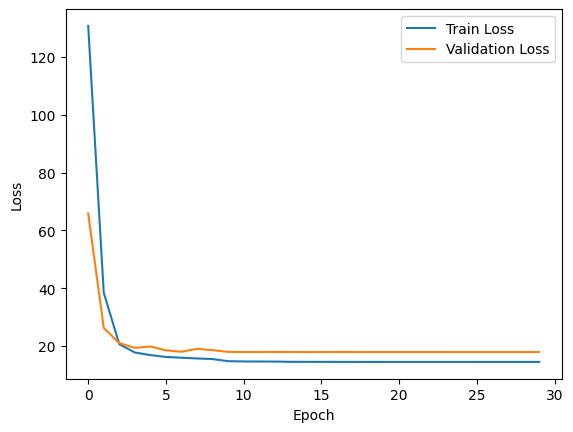

In [148]:
# Plot the loss curve
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

In [151]:
x_test = np.array(x_test)
y_test = np.array(y_test)
model.evaluate(x_test, y_test, batch_size=batch_size)

624/624 [==============================] - 4s 6ms/step - loss: 14.2345


14.234450340270996

In [150]:
num_samples = 10
X = model.predict(np.array(x_test[:num_samples]))
for i in range(num_samples):
  x_out = X[i]
  y_out = y_test[i]
  print(f'Prediction:   {x_out} \nGround Truth: {y_out} \n')


1/1 [==============================] - 1s 1s/step
Prediction:   [-1.1479645 -5.432781 ] 
Ground Truth: [ 0.  -6.7] 

Prediction:   [ 0.6009805 -4.477495 ] 
Ground Truth: [ 1.7 -3.3] 

Prediction:   [ 2.3134758 -3.5034373] 
Ground Truth: [ 0.6 -3.9] 

Prediction:   [-1.1670179 -5.785618 ] 
Ground Truth: [ -1.7 -10. ] 

Prediction:   [ 3.6052802 -2.692013 ] 
Ground Truth: [ 1.7 -3.3] 

Prediction:   [ 2.7142923 -3.706735 ] 
Ground Truth: [ 3.9 -6.1] 

Prediction:   [ 6.604291 -0.480381] 
Ground Truth: [ 9.4 -1.7] 

Prediction:   [7.3109035  0.13249147] 
Ground Truth: [9.4 2.8] 

Prediction:   [ 6.397623  -0.5526464] 
Ground Truth: [ 6.1 -2.8] 

Prediction:   [8.779697  1.4938748] 
Ground Truth: [ 5.  -3.3] 

